# Clustering

A centroid-based clustering approach based on the toxicity features of the comments could help identify different groups of toxic comments


In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kneed import KneeLocator
import numpy as np
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
#csv file
df = pd.read_csv("../.csv")
df_tox = df.iloc[:, 4:10] #toxicity features

In [5]:
#toxic dataframe
df_tox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724581 entries, 0 to 8724580
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   toxicity         float64
 1   severe_toxicity  float64
 2   obscene          float64
 3   threat           float64
 4   insult           float64
 5   identity_attack  float64
dtypes: float64(6)
memory usage: 399.4 MB


In [6]:
X = df_tox.values

In [7]:
# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

<h2>K-means</h2>

In [8]:
#select number of clusters
sse_list = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)



In [9]:
sse_list

In [10]:
range(2,len(sse_list)+2)

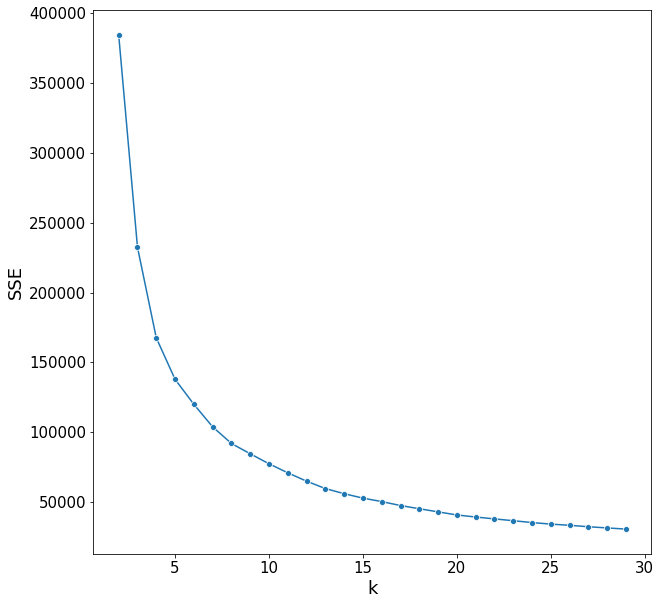

In [12]:

plt.figure(figsize=(10,10))
sns.lineplot(x=range(2,len(sse_list)+2), y=sse_list, marker='o')
plt.xlabel('k', fontsize=18)  
plt.ylabel('SSE', fontsize=18)  
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)  
plt.show()



In [12]:
kn = KneeLocator(range(len(sse_list)), sse_list, curve='convex', direction='decreasing')
print(kn.knee) #5

In [13]:
#kmeans application
kmeans = KMeans(n_clusters=5, random_state=0)
df_tox['cluster'] = kmeans.fit_predict(df_tox)


In [14]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
#number of comments per cluster

labels {0: 310902, 1: 7035262, 2: 318219, 3: 476205, 4: 583993}
sse 132001.87528067402


In [15]:
#centroids values per kind of toxicity
centroids = kmeans.cluster_centers_
for i in range(0, len(centroids)):
    print(i, centroids[i])

0 [0.97603098 0.16698228 0.88640954 0.03244292 0.75888822 0.11752163]
1 [0.01553948 0.00015102 0.00143224 0.00029413 0.00088239 0.00076048]
2 [0.76303745 0.00931588 0.17953445 0.04878939 0.24527736 0.09201316]
3 [0.88938942 0.04264463 0.81087792 0.00578412 0.19979626 0.01400393]
4 [0.36943386 0.00176214 0.08078474 0.01027671 0.0352262  0.02019977]


In [16]:
#cluster insights
cluster_means = df_tox.groupby('cluster').mean()
print("Media delle feature per cluster:")
print(cluster_means)


Media delle feature per cluster:
         toxicity  severe_toxicity   obscene    threat    insult  \
cluster                                                            
0        0.976021         0.166937  0.886335  0.032436  0.758793   
1        0.015527         0.000151  0.001430  0.000294  0.000882   
2        0.763020         0.009308  0.178751  0.048877  0.245142   
3        0.889198         0.042606  0.810620  0.005783  0.199714   
4        0.369126         0.001761  0.080878  0.010233  0.035179   

         identity_attack  
cluster                   
0               0.117503  
1               0.000760  
2               0.092067  
3               0.014010  
4               0.020161  


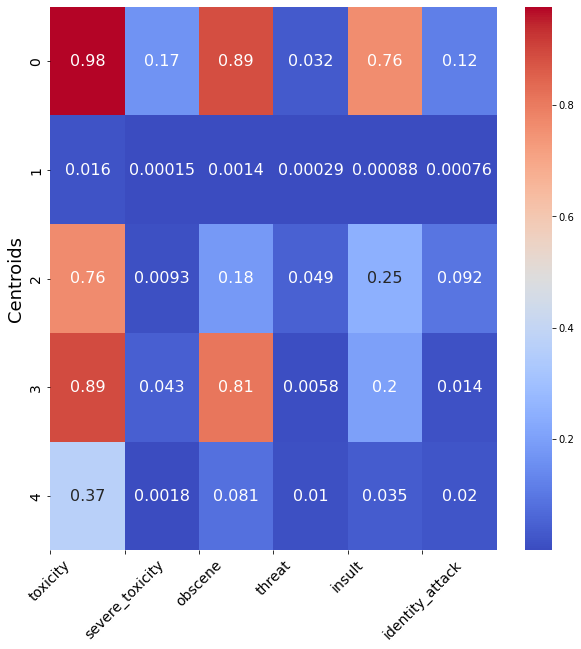

In [23]:
#centroids heatmap 
toxicities=["toxicity","severe_toxicity","obscene","threat","insult","identity_attack"]
data = np.array(centroids)

plt.figure(figsize=(10, 10))
sns.heatmap(data, annot=True, cmap="coolwarm", cbar=True, annot_kws={"size": 16})


 
    
plt.xticks(ticks=np.arange(len(toxicities)), labels=toxicities)
plt.ylabel("Centroids")
plt.xticks(rotation=45)

#plt.xlabel("Toxicities", fontsize=18)  
plt.xticks(ticks=np.arange(len(toxicities)), labels=toxicities, fontsize=14)  
plt.ylabel("Centroids", fontsize=18)  
plt.yticks(fontsize=14)  


plt.show()


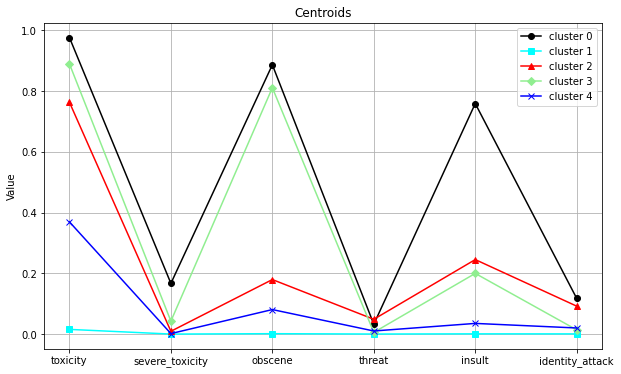

In [13]:
#centroids lineplot
colors = ['#000000', '#00FFFF', '#FF0000', '#90EE90', '#0000FF']
markers = ["o","s","^","D","x"]
toxicities=["toxicity","severe_toxicity","obscene","threat","insult","identity_attack"]

plt.figure(figsize=(10,6))

for i in range(0, 5):
    plt.plot(list(centroids[i]), marker=markers[i], label='cluster '+str(i), color=colors[i])


plt.xticks(ticks=range(len(toxicities)), labels=toxicities)


plt.title("Centroids")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.show()

In [18]:
#new column with the cluster of each comment
df["cluster"] = df_tox["cluster"]

In [23]:
#esport file
#df.to_csv("../file_csv/PIANO_comments.csv", index=False)